数据来源  https://archive.ics.uci.edu/ml/datasets/Adult

任务目的(二分类)：
预测每个人的年收入是否超过50k

In [1]:
#import tensorflow as tf
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

## 读取并查看数据

In [3]:
adult_data = pd.read_csv('adult.data', sep=',', names=[i for i in range(15)])
adult_data = pd.DataFrame(adult_data)
adult_data.columns = ['age','workclass','fnlwgt','education','education-num',
                'marital-status','occupation','relationship','race','sex',
                'capital-gain','capital-loss','hours-per-week','native-country',
                'year-income']

In [4]:
pd.DataFrame(adult_data.dtypes).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,year-income
0,int64,object,int64,object,int64,object,object,object,object,object,int64,int64,int64,object,object


查看是否存在相同类别但输入不同的存在

In [5]:
ob = ['workclass','marital-status','occupation','relationship','race','sex','native-country','year-income']
for x in ob:
    print(x,": ",set(adult_data[x]),'\n')

workclass :  {' Federal-gov', ' Private', ' Without-pay', ' ?', ' Self-emp-not-inc', ' Self-emp-inc', ' State-gov', ' Local-gov', ' Never-worked'} 

marital-status :  {' Married-AF-spouse', ' Never-married', ' Widowed', ' Married-civ-spouse', ' Married-spouse-absent', ' Divorced', ' Separated'} 

occupation :  {' Sales', ' Tech-support', ' Handlers-cleaners', ' Protective-serv', ' Prof-specialty', ' Farming-fishing', ' Adm-clerical', ' Exec-managerial', ' ?', ' Machine-op-inspct', ' Transport-moving', ' Priv-house-serv', ' Other-service', ' Craft-repair', ' Armed-Forces'} 

relationship :  {' Other-relative', ' Own-child', ' Not-in-family', ' Husband', ' Wife', ' Unmarried'} 

race :  {' Other', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' White'} 

sex :  {' Male', ' Female'} 

native-country :  {' Greece', ' Italy', ' France', ' Canada', ' Hong', ' Taiwan', ' Philippines', ' Columbia', ' Portugal', ' China', ' Haiti', ' Vietnam', ' Puerto-Rico', ' Mexico', ' Honduras', '

In [6]:
adult_test = pd.read_csv('adult.test', sep=',', names=[i for i in range(15)])
adult_test = pd.DataFrame(adult_test).iloc[1:,:]
adult_test.columns = ['age','workclass','fnlwgt','education','education-num',
                'marital-status','occupation','relationship','race','sex',
                'capital-gain','capital-loss','hours-per-week','native-country',
                'year-income']

In [7]:
pd.DataFrame(adult_test.dtypes).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,year-income
0,object,object,float64,object,float64,object,object,object,object,object,float64,float64,float64,object,object


In [8]:
for x in ob:
    print(x,": ",set(adult_test[x]),'\n')

workclass :  {' Federal-gov', ' Private', ' Without-pay', ' ?', ' Self-emp-not-inc', ' Self-emp-inc', ' State-gov', ' Local-gov', ' Never-worked'} 

marital-status :  {' Married-AF-spouse', ' Never-married', ' Widowed', ' Married-civ-spouse', ' Married-spouse-absent', ' Divorced', ' Separated'} 

occupation :  {' Protective-serv', ' Tech-support', ' Sales', ' Handlers-cleaners', ' Farming-fishing', ' Prof-specialty', ' Adm-clerical', ' Exec-managerial', ' ?', ' Machine-op-inspct', ' Transport-moving', ' Priv-house-serv', ' Other-service', ' Craft-repair', ' Armed-Forces'} 

relationship :  {' Other-relative', ' Not-in-family', ' Own-child', ' Husband', ' Wife', ' Unmarried'} 

race :  {' Other', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo', ' White'} 

sex :  {' Male', ' Female'} 

native-country :  {' Greece', ' Italy', ' France', ' Canada', ' Hong', ' Taiwan', ' Philippines', ' Columbia', ' Portugal', ' China', ' Haiti', ' Vietnam', ' Puerto-Rico', ' Mexico', ' Honduras', '

## 数据预处理

数据处理思路：  
考虑到下面会使用交叉验证以及网格搜索进行最优参数选择，在交叉验证中，valid会被fit到模型中进行训练，可能会导致模型对train、valid过拟合。因此将训练集adult_data划分为train、valid，选择将train作为训练集进行交叉验证，得到最优参数，再为使用最优参数的模型学习valid数据，在adult_test中检验模型学习得分。  
对于adult_data：选择去除噪声数据（去除缺失值），拟合得到最优学习器。  
对于adult_test：将其视为需要模型预测的最终数据集，当使用模型进行预测时，应对任意一个不完美的样本都做出预测，因此选择补充缺失值。

In [9]:
adult_data = adult_data.drop(['education'],axis=1)

In [10]:
adult_test = adult_test.drop(['education'],axis=1)

### 缺失值处理

In [11]:
import missingno as msno

#### adult_data

In [12]:
adult_data = adult_data.replace(' ?',np.nan)

<AxesSubplot:>

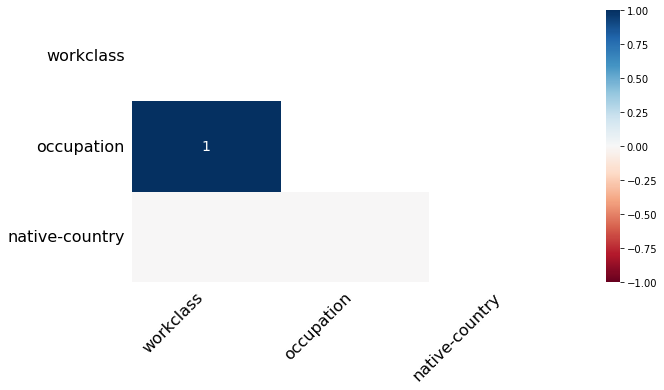

In [13]:
msno.heatmap(adult_data,figsize=(10,5))

可以得知，occupation与workclass同步缺失

查看缺失值出现的维度

<AxesSubplot:>

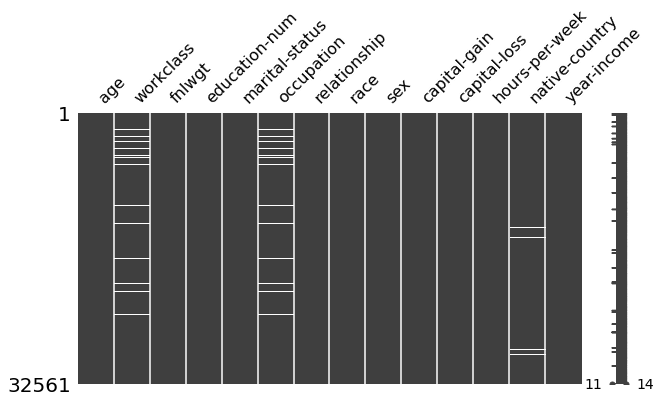

In [14]:
msno.matrix(adult_data,figsize=(10,5))

In [15]:
missing_values_count = adult_data.isnull().sum()
missing_values_count

age                  0
workclass         1836
fnlwgt               0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
year-income          0
dtype: int64

由于occupation相较于workclass有更多缺失值，下查看occupation缺失时workclass的值

In [16]:
adult_data[['occupation','workclass']][(adult_data['occupation'].isna()==True) & (adult_data['workclass'].isna()==False)]

,occupation,workclass
5361,NaN,Never-worked
10845,NaN,Never-worked
14772,NaN,Never-worked
20337,NaN,Never-worked
23232,NaN,Never-worked
32304,NaN,Never-worked
32314,NaN,Never-worked


当occupation缺失时，workclass表现为'Never-worked'，因此将这部分值填充为' Never-worked'

In [17]:
adult_data.loc[(adult_data['occupation'].isna()==True) & (adult_data['workclass'].isna()==False),'occupation'] = ' Never-worked'

In [18]:
adult_data[['occupation','workclass']][(adult_data['occupation'].isna()==True) & (adult_data['workclass'].isna()==False)]

,occupation,workclass


去除缺失值

In [19]:
adult_data = adult_data.dropna()

In [20]:
missing_values_count = adult_data.isnull().sum()
missing_values_count

age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
year-income       0
dtype: int64

### adult_test

In [21]:
adult_test = adult_test.replace(' ?',np.nan)

<AxesSubplot:>

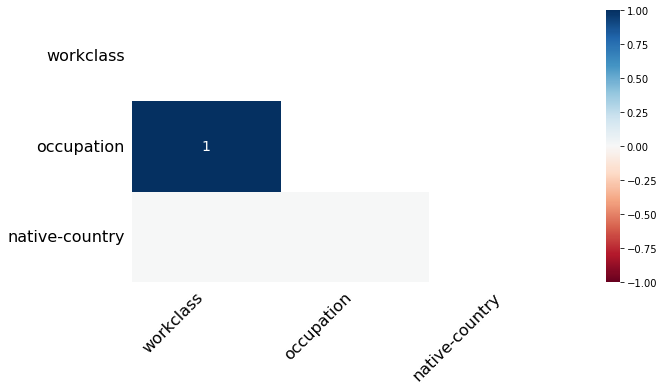

In [22]:
msno.heatmap(adult_test,figsize=(10,5))

<AxesSubplot:>

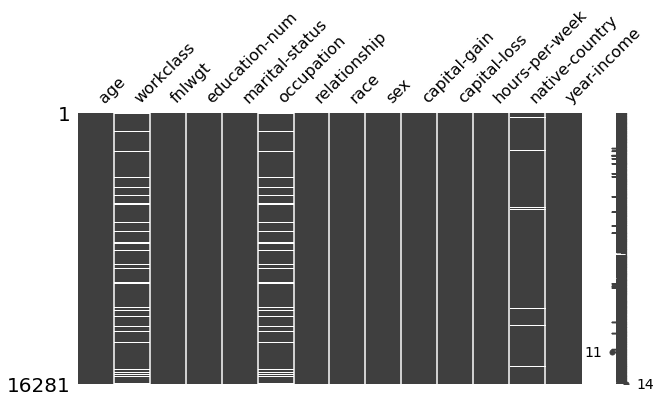

In [23]:
msno.matrix(adult_test,figsize=(10,5))

In [24]:
missing_values_count = adult_test.isnull().sum()
missing_values_count

age                 0
workclass         963
fnlwgt              0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
year-income         0
dtype: int64

In [25]:
adult_test[['occupation','workclass']][(adult_test['occupation'].isna()==True) & (adult_test['workclass'].isna()==False)]

,occupation,workclass
8786,NaN,Never-worked
11608,NaN,Never-worked
13899,NaN,Never-worked


In [26]:
adult_test.loc[(adult_test['occupation'].isna()==True) & (adult_test['workclass'].isna()==False),'occupation'] = ' Never-worked'

#### 使用众数填充缺失值

In [27]:
adult_test['occupation'].value_counts().head(1)

 Prof-specialty    2032
Name: occupation, dtype: int64

In [28]:
adult_test['workclass'].value_counts().head(1)

 Private    11210
Name: workclass, dtype: int64

In [29]:
adult_test['native-country'].value_counts().head(1)

 United-States    14662
Name: native-country, dtype: int64

In [30]:
adult_test['occupation'] = adult_test['occupation'].fillna(' Prof-specialty')
adult_test['workclass'] = adult_test['workclass'].fillna(' Private')
adult_test['native-country'] = adult_test['native-country'].fillna(' United-States')

In [31]:
missing_values_count = adult_test.isnull().sum()
missing_values_count

age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
year-income       0
dtype: int64

In [32]:
adult_test.dtypes

age                object
workclass          object
fnlwgt            float64
education-num     float64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain      float64
capital-loss      float64
hours-per-week    float64
native-country     object
year-income        object
dtype: object

In [33]:
adult_test.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,year-income
1,25,Private,226802.0,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,Private,103497.0,10.0,Never-married,Prof-specialty,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


### 获取x y

In [34]:
x = adult_data.drop(['year-income'],axis=1)
y = pd.get_dummies(adult_data.iloc[:,-1])[' <=50K']

In [35]:
x_test_pre = adult_test.drop(['year-income'],axis=1)
y_test = pd.get_dummies(adult_test.iloc[:,-1])[' <=50K.']

### 分类型数据编码

In [36]:
t = [
    ('ord',OrdinalEncoder(),[1,4,5,12]),
    ('onehot',OneHotEncoder(),[6,7,8]),
]
coltrans = ColumnTransformer(t,remainder='passthrough')

In [37]:
coltrans.fit_transform(x).shape

(30169, 23)

In [38]:
x_ec1 = coltrans.fit_transform(x)

In [39]:
x_test = coltrans.fit_transform(x_test_pre)

In [40]:
x_ec1.shape

(30169, 23)

In [41]:
x_test.shape

(16281, 23)

### 划分数据集

In [42]:
x_train,x_valid,y_train,y_valid = train_test_split(x_ec1,y,stratify=y,train_size=0.5,random_state=0)

## 分类学习器

### 逻辑回归

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
lr_pipe = Pipeline([
        ('std_scaler',StandardScaler()),
        ('log_reg',LogisticRegression(max_iter=5000))
    ])

In [45]:
param_grid_lr = [
    {'log_reg__penalty':['l1'],
     'log_reg__solver':['liblinear'],
     'log_reg__C':np.linspace(0.1,2,4)
    },
    {'log_reg__penalty':['l2'],
     'log_reg__solver':['liblinear','newton-cg','sag','lbfgs'],
     'log_reg__C':np.linspace(0.1,2,4)
    }
]

lr_gs = GridSearchCV(lr_pipe,param_grid_lr,refit=True,cv=5,n_jobs=-1,scoring='f1_weighted')

In [46]:
lr_gs.fit(x_train,y_train)
print('验证参数：\n',lr_gs.best_params_)

验证参数：
 {'log_reg__C': 1.3666666666666667, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}


In [47]:
print('验证参数：\n',lr_gs.best_score_)

验证参数：
 0.8351714248643394


In [48]:
lr_pipe_best = Pipeline([
        ('std_scaler',StandardScaler()),
        ('log_reg',LogisticRegression(C=1.37,penalty='l2',solver='liblinear'))
    ])

In [49]:
lr_pipe_best.fit(x_valid,y_valid)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('log_reg', LogisticRegression(C=1.37, solver='liblinear'))])

In [50]:
ls_acc_score = accuracy_score(y_valid,lr_pipe_best.predict(x_valid))
ls_f1_score = f1_score(y_valid,lr_pipe_best.predict(x_valid),average='weighted')
print('accuracy: ',ls_acc_score,'\nF1_score: ',ls_f1_score)

accuracy:  0.8397746105402718 
F1_score:  0.833182444220468


test预测得分

In [51]:
ls_tacc_score = accuracy_score(y_test,lr_pipe_best.predict(x_test))
ls_tf1_score = f1_score(y_test,lr_pipe_best.predict(x_test),average='weighted')
print('Test accuracy: ',ls_tacc_score,'\nTest F1_score: ',ls_tf1_score)

Test accuracy:  0.8422701308273448 
Test F1_score:  0.8358849883838676


### SVM

In [52]:
from sklearn.svm import SVC

In [53]:
svm_pipe = Pipeline([
    ('std_scaler',StandardScaler()),
    ('svc',SVC())
])

In [56]:
param_grid_svc = [
    {
        'svc__C':list(range(15,20)),
        'svc__kernel':['poly'],
        'svc__degree':[1,2,3]},
    {
        'svc__C':list(range(15,20)),
        'svc__kernel':['rbf'],
        'svc__gamma':range(1,4)}
]
svc_gs = GridSearchCV(svm_pipe,param_grid_svc,verbose=2,refit=True,cv=5,n_jobs=-1,scoring='f1_weighted')

In [57]:
svc_gs.fit(x_train,y_train)
print('验证参数：\n',svc_gs.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
验证参数：
 {'svc__C': 18, 'svc__degree': 2, 'svc__kernel': 'poly'}


In [58]:
svm_pipe_best = Pipeline([
    ('onehot',OneHotEncoder(handle_unknown='ignore')),
    ('std_scaler',StandardScaler(with_mean=False)),
    ('svc',SVC(C=18,kernel='poly',degree=2))
])

In [59]:
svm_pipe_best.fit(x_valid,y_valid)

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('std_scaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=18, degree=2, kernel='poly'))])

In [60]:
svm_acc_score = accuracy_score(y_valid,svm_pipe_best.predict(x_valid))
svm_f1_score = f1_score(y_valid,svm_pipe_best.predict(x_valid),average='weighted')
print('accuracy: ',svm_acc_score,'\nF1_score: ',svm_f1_score)

accuracy:  0.9736161750082863 
F1_score:  0.9733422015155414


In [61]:
svm_tacc_score = accuracy_score(y_test,svm_pipe_best.predict(x_test))
svm_tf1_score = f1_score(y_test,svm_pipe_best.predict(x_test),average='weighted')
print('Test accuracy: ',svm_tacc_score,'\nTest F1_score: ',svm_tf1_score)

Test accuracy:  0.8083655795098581 
Test F1_score:  0.7870363480009155


### KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
knn_pipe = Pipeline([
    ('std_scaler',StandardScaler(with_mean=False)),
    ('knn',KNeighborsClassifier(algorithm='brute'))
])

In [64]:
param_grid_knn = {
    'knn__weights':['uniform'],
    'knn__n_neighbors':list(range(13,16))
}

knn_gs = GridSearchCV(knn_pipe,param_grid_knn,verbose=2,refit=True,cv=5,n_jobs=-1,scoring='f1_weighted')

In [65]:
knn_gs.fit(x_train,y_train)
print('验证参数：\n',knn_gs.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
验证参数：
 {'knn__n_neighbors': 14, 'knn__weights': 'uniform'}


In [66]:
knn_pipe_best = Pipeline([
    ('std_scaler',StandardScaler(with_mean=False)),
    ('knn',KNeighborsClassifier(n_neighbors=14, weights='uniform',algorithm='brute'))
])

In [67]:
knn_pipe_best.fit(x_valid,y_valid)

Pipeline(steps=[('std_scaler', StandardScaler(with_mean=False)),
                ('knn',
                 KNeighborsClassifier(algorithm='brute', n_neighbors=14))])

In [68]:
knn_acc_score = accuracy_score(y_valid,knn_pipe_best.predict(x_valid))
knn_f1_score = f1_score(y_valid,knn_pipe_best.predict(x_valid),average='weighted')
print('accuracy: ',knn_acc_score,'\nF1_score: ',knn_f1_score)

accuracy:  0.8456082200861783 
F1_score:  0.8422978165823761


In [69]:
knn_tacc_score = accuracy_score(y_test,knn_pipe_best.predict(x_test))
knn_tf1_score = f1_score(y_test,knn_pipe_best.predict(x_test),average='weighted')
print('Test accuracy: ',knn_tacc_score,'\nTest F1_score: ',knn_tf1_score)

Test accuracy:  0.8331183588231681 
Test F1_score:  0.8301163392624511


### 决策树

In [70]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz

In [77]:
dtc_pipe = Pipeline([
    ('dtc',DecisionTreeClassifier(random_state=0))
])

In [78]:
dtc_params = {
    'dtc__criterion':['gini','entropy'],
    'dtc__max_depth':[5,6,7,8],
    'dtc__min_samples_leaf':[1,2,3],
    'dtc__class_weight':['balanced']
}
dtc_gs = GridSearchCV(dtc_pipe,dtc_params,cv=5,n_jobs=-1,scoring='f1_weighted')

In [79]:
dtc_gs.fit(x_train,y_train)
print('验证参数：\n',dtc_gs.best_params_)

验证参数：
 {'dtc__class_weight': 'balanced', 'dtc__criterion': 'gini', 'dtc__max_depth': 7, 'dtc__min_samples_leaf': 1}


In [80]:
print('train best score： ',dtc_gs.best_score_)

train best score：  0.8112655421946346


In [81]:
dtc_pipe_std = Pipeline([
    ('std_scaler',StandardScaler()),
    ('dtc',DecisionTreeClassifier(random_state=0))
])

In [83]:
dtc_params_std = {
    'dtc__criterion':['gini','entropy'],
    'dtc__max_depth':[5,6,7,8],
    'dtc__min_samples_leaf':[1,2,3],
    'dtc__class_weight':['balanced']
}
dtc_gs_std = GridSearchCV(dtc_pipe_std,dtc_params_oh,cv=5,n_jobs=-1,scoring='f1_weighted')

In [84]:
dtc_gs_std.fit(x_train,y_train)
print('验证参数：\n',dtc_gs_std.best_params_)

验证参数：
 {'dtc__class_weight': 'balanced', 'dtc__criterion': 'gini', 'dtc__max_depth': 7, 'dtc__min_samples_leaf': 1}


In [86]:
print('train best score： ',dtc_gs_std.best_score_)

train best score：  0.8112655421946346


In [87]:
dtc_pipe_best = Pipeline([
    ('dtc',DecisionTreeClassifier(
        random_state=0,class_weight='balanced',criterion='gini',
        max_depth=7,min_samples_leaf=1
    ))
])

In [88]:
dtc_pipe_best.fit(x_valid,y_valid)

Pipeline(steps=[('dtc',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        random_state=0))])

In [89]:
dtc_acc_score = accuracy_score(y_valid,dtc_pipe_best.predict(x_valid))
dtc_f1_score = f1_score(y_valid,dtc_pipe_best.predict(x_valid),average='weighted')
print('accuracy: ',dtc_acc_score,'\nF1_score: ',dtc_f1_score)

accuracy:  0.7992045077891946 
F1_score:  0.810795782424356


In [90]:
dtc_tacc_score = accuracy_score(y_test,dtc_pipe_best.predict(x_test))
dtc_tf1_score = f1_score(y_test,dtc_pipe_best.predict(x_test),average='weighted')
print('Test accuracy: ',dtc_tacc_score,'\nTest F1_score: ',dtc_tf1_score)

Test accuracy:  0.7958970579202752 
Test F1_score:  0.808354750301648


### 随机森林

In [91]:
from sklearn.ensemble import RandomForestClassifier

In [92]:
rf_pipe = Pipeline([
    ('rf',RandomForestClassifier(random_state=2022))
])

In [96]:
rf_params = {
              'rf__n_estimators':[156,158,160],
              'rf__max_depth':[18,20,22],
              'rf__min_samples_leaf':[1,2],
              'rf__min_samples_split':[8,10,12,14],
              'rf__criterion':['gini']
             }
rf_gs = GridSearchCV(rf_pipe,rf_params,cv=5,n_jobs=-1,scoring='f1_weighted')

In [97]:
rf_gs.fit(x_train,y_train.ravel())
print('验证参数：\n',rf_gs.best_params_)

验证参数：
 {'rf__criterion': 'gini', 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 160}


In [98]:
print('f1_score：',rf_gs.best_score_)

f1_score： 0.857564899897391


In [99]:
rf_pipe_best = Pipeline([
    ('ord',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)),
    ('rf',RandomForestClassifier(random_state=0,n_estimators=160,criterion='gini',max_depth=20,
                                 max_features='auto',min_samples_leaf=1,min_samples_split=10))
])

In [100]:
rf_pipe_best.fit(x_valid,y_valid.ravel())

Pipeline(steps=[('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('rf',
                 RandomForestClassifier(max_depth=20, min_samples_split=10,
                                        n_estimators=160, random_state=0))])

In [101]:
rf_acc_score = accuracy_score(y_valid,rf_pipe_best.predict(x_valid))
rf_f1_score = f1_score(y_valid,rf_pipe_best.predict(x_valid),average='weighted')
print('accuracy: ',rf_acc_score,'\nF1_score: ',rf_f1_score)

accuracy:  0.9101756711965528 
F1_score:  0.9066024311886012


In [102]:
rf_tacc_score = accuracy_score(y_test,rf_pipe_best.predict(x_test))
rf_tf1_score = f1_score(y_test,rf_pipe_best.predict(x_test),average='weighted')
print('Test accuracy: ',rf_tacc_score,'\nTest F1_score: ',rf_tf1_score)

Test accuracy:  0.8282046557336773 
Test F1_score:  0.7905120897446493


### XGBoost

In [47]:
from xgboost import XGBClassifier,plot_importance

In [45]:
xgb = XGBClassifier()

[16:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


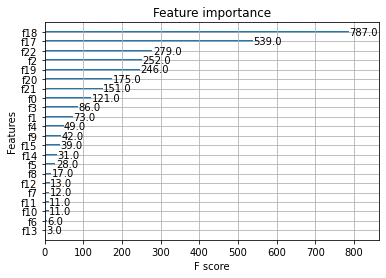

In [50]:
xgb.fit(x_train,y_train)
plot_importance(xgb)
plt.show()

In [64]:
param_grid = {
    'booster':['gbtree'],
    'gamma':[0.2],
    'max_depth':[5,7,9],
    'lambda':[1],
    'learning_rate':[0.02,0.04,0.06,0.08,0.1]
}
xgb_gs = GridSearchCV(xgb, param_grid, scoring="f1_weighted", n_jobs=-1, cv=5)

In [65]:
xgb_gs.fit(x_train,y_train.ravel())
print('验证参数：\n',xgb_gs.best_params_)

D:\anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
验证参数：
 {'booster': 'gbtree', 'gamma': 0.2, 'lambda': 1, 'learning_rate': 0.08, 'max_depth': 7}


In [66]:
print('f1_score：',xgb_gs.best_score_)

f1_score： 0.8683222807407235


In [72]:
xgb_best = XGBClassifier(
    booster='gbtree',
    gamma=0.2,
    max_depth=7,
    learning_rate=0.08
)

In [73]:
xgb_best.fit(x_valid,y_valid,)

[16:32:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.2, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.08, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [75]:
xgb_acc_score = accuracy_score(y_valid,xgb_best.predict(x_valid))
xgb_f1_score = f1_score(y_valid,xgb_best.predict(x_valid),average='weighted')
print('accuracy: ',xgb_acc_score,'\nF1_score: ',xgb_f1_score)

accuracy:  0.8896917467683129 
F1_score:  0.8859238363217704


In [78]:
xgb_tacc_score = accuracy_score(y_test,xgb_best.predict(x_test))
xgb_tf1_score = f1_score(y_test,xgb_best.predict(x_test),average='weighted')
print('Test accuracy: ',xgb_tacc_score,'\nTest F1_score: ',xgb_tf1_score)

Test accuracy:  0.8697254468398747 
Test F1_score:  0.8637446269772321


### LishtGBM

In [80]:
import lightgbm as lgb

In [103]:
parameters = {
    'max_depth': [10,12,14],
    'num_leaves': [60,70,80],
    'learning_rate':[0.01],
    'n_estimators':[80,90,100]
}

gbm = lgb.LGBMClassifier(objective = 'binary',
                         boosting_type='gbdt',
                         is_unbalance = True,
                         min_child_samples=21,
                         min_child_weight=0.001,
                        )
lgb_gs = GridSearchCV(gbm, param_grid=parameters, scoring='f1_weighted', cv=3)

In [104]:
lgb_gs.fit(x_train,y_train)
print('验证参数：\n',lgb_gs.best_params_)

验证参数：
 {'learning_rate': 0.01, 'max_depth': 14, 'n_estimators': 80, 'num_leaves': 60}


In [105]:
print('验证得分：\n',lgb_gs.best_score_)

验证得分：
 0.8539450515959567


In [108]:
lgb_best = lgb.LGBMClassifier(objective = 'binary',
                         boosting_type='gbdt',
                         is_unbalance = True,
                         min_child_samples=21,
                         min_child_weight=0.001,
                         learning_rate=0.01, 
                         max_depth=14, 
                         n_estimators=80, 
                         num_leaves=60
                        )

In [109]:
lgb_best.fit(x_valid,y_valid,)

LGBMClassifier(is_unbalance=True, learning_rate=0.01, max_depth=14,
               min_child_samples=21, n_estimators=80, num_leaves=60,
               objective='binary')

In [110]:
lgb_acc_score = accuracy_score(y_valid,lgb_best.predict(x_valid))
lgb_f1_score = f1_score(y_valid,lgb_best.predict(x_valid),average='weighted')
print('accuracy: ',lgb_acc_score,'\nF1_score: ',lgb_f1_score)

accuracy:  0.8613854822671528 
F1_score:  0.8589135676370917


In [111]:
lgb_tacc_score = accuracy_score(y_test,lgb_best.predict(x_test))
lgb_tf1_score = f1_score(y_test,lgb_best.predict(x_test),average='weighted')
print('Test accuracy: ',lgb_tacc_score,'\nTest F1_score: ',lgb_tf1_score)

Test accuracy:  0.8575640316933849 
Test F1_score:  0.8546714347530459
